# Computer Vision Validation



In [2]:
import torch
import pickle
import wallaroo
import os
import numpy as np
import json
import requests
import time
import pandas as pd
import datetime
from CVDemoUtils import CVDemo

from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from CVDemoUtils import CVDemo
cvDemo = CVDemo()
cvDemo.COCO_CLASSES_PATH = "models/coco_classes.pickle"


### Securely connect this Notebook to the Wallaroo Cluster

In [3]:
wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

Please log into the following URL in a web browser:

	https://doc-test.keycloak.wallaroocommunity.ninja/auth/realms/master/device?user_code=QUOS-BMRB

Login successful!


### Set the current workspace to "computer-vision"

In [4]:
# used for unique connection names

# import string
# import random

# suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

suffix='jch'

workspace_name = f'cv-retail{suffix}'

pipeline_name = 'cv-retail-pipeline'

In [5]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

pipeline = get_pipeline(pipeline_name)

### Upload model to wallaroo

In [6]:
# assuming they were uploaded - grab them

mobilenet_model_name = 'mobilenet'
# mobilenet_model_path = "./models/mobilenet.pt.onnx"

resnet_model_name = 'resnet'


def get_model(mname):
    modellist = wl.get_current_workspace().models()
    model = [m.versions()[0] for m in modellist if m.name() == mname]
    if len(model) <= 0:
        raise KeyError(f"model {mname} not found in this workspace")
    return model[0]

mobilenet_model = get_model(mobilenet_model_name)

resnet_model = get_model(resnet_model_name)

step_name = "cv-post-process-drift-detection"

module_post_process = get_model(step_name)


### Upload the post processing module code to Wallaroo

Next we will add our post processing anomoly detection file that will take the average of the confidences.  We will use this value to detect drift.</b>

In [6]:
# import pyarrow as pa

# field_boxes = pa.field('boxes', pa.list_(pa.list_(pa.float64(), 4)))
# field_classes = pa.field('classes', pa.list_(pa.int32()))
# field_confidences =  pa.field('confidences', pa.list_(pa.float64()))

# # field_boxes - will have a flattened array of the 4 coordinates representing the boxes.  128 entries
# # field_classes - will have 32 entries
# # field_confidences - will have 32 entries
# input_schema = pa.schema([field_boxes, field_classes, field_confidences])

# output_schema = pa.schema([
#     field_boxes,
#     field_classes,
#     field_confidences,
#     pa.field('avg_conf', pa.list_(pa.float64()))
# ])

In [7]:
# module_post_process = wl.upload_model("cv-post-process-drift-detection", 
#                                       "./models/post-process-drift-detection-arrow.py",
#                                       framework=Framework.PYTHON ).configure('python', 
#                                                                              input_schema=input_schema, 
#                                                                              output_schema=output_schema
#                                     )


### Reserve resources needed for this pipeline from the Wallaroo Cluster

In [7]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).replica_autoscale_min_max(minimum=2, maximum=5).cpus(1).memory("1Gi").build()

### Create the pipeline and add the post processing module as a step in the pipeline

In [9]:
#pipeline_name = 'cam-atl-1-anm'
#pipeline = wl.build_pipeline(pipeline_name) \
#            .add_model_step(mobilenet_model) \
#            .deploy(deployment_config = deployment_config)

In [8]:
# in case this was run before
pipeline.undeploy()
pipeline.clear()
pipeline.add_model_step(mobilenet_model)
pipeline.add_model_step(module_post_process)

name,cv-retail-pipeline
created,2023-07-28 19:26:41.215539+00:00
last_updated,2023-07-28 21:05:29.220812+00:00
deployed,False
tags,
versions,"e82d7f86-2646-4946-900e-e371d48c4c75, de2a9ad5-7a98-4a43-80d5-6e55a0c813f6, bfe5c1eb-e129-4093-99a2-8e588d4abcec, dc13ac9b-90c3-49d1-86f0-83c3d3186173, 8a067ab5-7423-4554-82ac-d75594fe4ca4, 71f5ffae-e74c-459b-b30a-b6a3ae260695, c9cfcb2d-d789-4cdd-8e62-b5108192179f, 5e1d35ef-fb98-4ffe-8344-93609046f025, 3bd9a6ce-4ccb-4a93-9ccb-ae559e91048c"
steps,mobilenet


In [26]:
pipeline.deploy(deployment_config = deployment_config)

Please log into the following URL in a web browser:

	https://doc-test.keycloak.wallaroocommunity.ninja/auth/realms/master/device?user_code=KHSA-YYRU

Login successful!


name,cv-retail-pipeline
created,2023-07-28 19:26:41.215539+00:00
last_updated,2023-08-04 17:05:09.154597+00:00
deployed,True
tags,
versions,"2cbd3190-0e76-4671-8925-b236f46dfb1c, 95162b60-10a7-4663-bb9e-5bf76f69d665, e82d7f86-2646-4946-900e-e371d48c4c75, de2a9ad5-7a98-4a43-80d5-6e55a0c813f6, bfe5c1eb-e129-4093-99a2-8e588d4abcec, dc13ac9b-90c3-49d1-86f0-83c3d3186173, 8a067ab5-7423-4554-82ac-d75594fe4ca4, 71f5ffae-e74c-459b-b30a-b6a3ae260695, c9cfcb2d-d789-4cdd-8e62-b5108192179f, 5e1d35ef-fb98-4ffe-8344-93609046f025, 3bd9a6ce-4ccb-4a93-9ccb-ae559e91048c"
steps,mobilenet


In [27]:
pipeline.status()

{'status': 'Running',
 'details': [],
 'engines': [{'ip': '10.244.3.228',
   'name': 'engine-8668758f46-fdllr',
   'status': 'Running',
   'reason': None,
   'details': [],
   'pipeline_statuses': {'pipelines': [{'id': 'cv-retail-pipeline',
      'status': 'Running'}]},
   'model_statuses': {'models': [{'name': 'cv-post-process-drift-detection',
      'version': '96f3d490-37fc-4c6a-a731-04d19b977443',
      'sha': 'f60c8ca55c6350d23a4e76d24cc3e5922616090686e88c875fadd6e79c403be5',
      'status': 'Running'},
     {'name': 'mobilenet',
      'version': '1f3e1ff3-92f4-4b38-88a2-e3425c93b0a9',
      'sha': '9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830',
      'status': 'Running'}]}}],
 'engine_lbs': [{'ip': '10.244.4.156',
   'name': 'engine-lb-584f54c899-tjqht',
   'status': 'Running',
   'reason': None,
   'details': []}],
 'sidekicks': []}

In [28]:
pipeline.steps()

[{'ModelInference': {'models': [{'name': 'mobilenet', 'version': '1f3e1ff3-92f4-4b38-88a2-e3425c93b0a9', 'sha': '9044c970ee061cc47e0c77e20b05e884be37f2a20aa9c0c3ce1993dbd486a830'}]}},
 {'ModelInference': {'models': [{'name': 'cv-post-process-drift-detection', 'version': '96f3d490-37fc-4c6a-a731-04d19b977443', 'sha': 'f60c8ca55c6350d23a4e76d24cc3e5922616090686e88c875fadd6e79c403be5'}]}}]

## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

# Run inference using the SDK 

Now lets have the model detect the objects on the image by running inference and extracting the results 

In [48]:
import datetime
import time

startBaseline = datetime.datetime.now()
startTime = time.time()

sample_images = [
    "./data/images/input/example/coats-jackets.png",
    "./data/images/input/example/dairy_bottles.png",
    "./data/images/input/example/dairy_products.png",
    "./data/images/input/example/example_01.jpg",
    "./data/images/input/example/example_02.jpg",
    "./data/images/input/example/example_03.jpg",
    "./data/images/input/example/example_04.jpg",
    "./data/images/input/example/example_05.jpg",
    "./data/images/input/example/example_06.jpg",
    "./data/images/input/example/example_09.jpg",
    "./data/images/input/example/example_dress.jpg",
    "./data/images/input/example/example_shoe.jpg",
    "./data/images/input/example/frame5244.jpg",
    "./data/images/input/example/frame8744.jpg",
    "./data/images/input/example/product_cheeses.png",
    "./data/images/input/example/store-front.png",
    "./data/images/input/example/vegtables_poor_identification.jpg"
]

baseline_images = [
    "./data/images/input/example/example_02.jpg",
    "./data/images/input/example/example_05.jpg",
    "./data/images/input/example/example_dress.jpg",
]

bad_images = [
    "./data/images/input/example/coats-jackets.png",
    "./data/images/input/example/frame8744.jpg",
]

# # do an inference off each image

image_confidence = pd.DataFrame(columns=["path", "confidence"])

inference_list = []

# convert all of these into a parallel infer list, then one parallel infer to cut down time
for image in baseline_images:
    width, height = 640, 480
    dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )
    
    inference_list.append(dfImage)
    
display(inference_list)
startTime = time.time()
parallel_results = await pipeline.parallel_infer(tensor_list=inference_list, timeout=20, num_parallel=16, retries=2)
display(parallel_results)
endTime = time.time()

endBaseline = datetime.datetime.now()

[                                              tensor
 0  [[[[0.18039216 0.18039216 0.18039216 0.1803921...,
                                               tensor
 0  [[[[0.12156863 0.07450981 0.04705882 0.0431372...,
                                               tensor
 0  [[[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...]

[                     time                                          in.tensor  \
 0 2023-08-04 18:09:49.757  [0.180392161, 0.180392161, 0.180392161, 0.1803...   
 
            out.avg_conf                                          out.boxes  \
 0  [0.9998139739036561]  [[202.2082061767578, 273.072021484375, 606.092...   
 
   out.classes       out.confidences  check_failures  
 0         [5]  [0.9998139739036561]               0  ,
                      time                                          in.tensor  \
 0 2023-08-04 18:09:50.589  [0.1215686277, 0.0745098069, 0.0470588244, 0.0...   
 
            out.avg_conf                                          out.boxes  \
 0  [0.4765825836131201]  [[273.4986877441406, 88.34534454345703, 539.96...   
 
                                   out.classes  \
 0  [19, 1, 18, 1, 1, 3, 8, 1, 19, 1, 3, 1, 3]   
 
                                      out.confidences  check_failures  
 0  [0.9991384744644161, 0.9950750470161431, 0.929...              

## Build Assay



In [49]:
assay_name = "cv assay 01"
assay_builder = wl.build_assay(assay_name, 
                               pipeline, 
                               step_name, 
                               startBaseline, 
                               endBaseline).add_iopath("output avg_conf 0")

In [50]:
baseline_run = assay_builder.build().interactive_baseline_run()

baseline_run.baseline_stats()

,Baseline
count,3
min,0.476583
max,0.999814
mean,0.82118
median,0.987145
std,0.243722
start,2023-08-04T18:09:41.343393Z
end,2023-08-04T18:09:54.231417Z


## Build the assay

This may take about 5 - 10 minutes to run to generate items in the window.

In [54]:
## Blank space to run more data

import time

assay_start = datetime.datetime.now()

regular_images = []

bad_images = []

for image in bad_images:
    width, height = 640, 480
    dfImage, resizedImage = cvDemo.loadImageAndConvertToDataframe(image, 
                                                              width, 
                                                              height
                                                              )
    
    bad_images.append(dfImage)
    
for i in range(3):
    parallel_results = await pipeline.parallel_infer(tensor_list=bad_images, timeout=20, num_parallel=16, retries=2)
    time.sleep(35)
    parallel_results = await pipeline.parallel_infer(tensor_list=inference_list, timeout=20, num_parallel=16, retries=2)
    time.sleep(35)


assay_end = datetime.datetime.now()


In [55]:
# blank space for setting assay parameters, creating and examining an interactive assay

# now set up our interactive assay based on the window set above.

assay_builder = assay_builder.add_run_until(assay_end)

# We don't have many records at the moment, so set the width to 1 minute so it'll slice each 
# one minute interval into a window to analyze
assay_builder.window_builder().add_width(minutes=1).add_interval(minutes=1)

# Build the assay and then do an interactive run rather than waiting for the next interval
assay_config = assay_builder.build()
assay_results = assay_config.interactive_run()

Generated 8 analyses


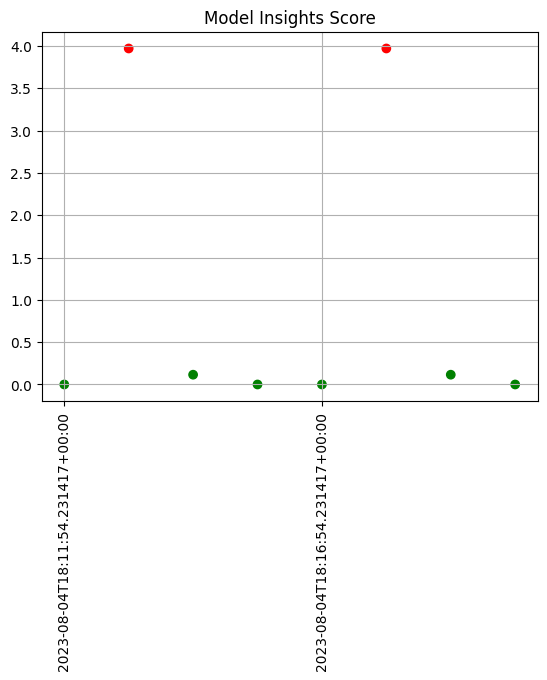

In [56]:
# Show how many assay windows were analyzed, then show the chart
print(f"Generated {len(assay_results)} analyses")
assay_results.chart_scores()

In [57]:
pipeline.undeploy()